#### Assignments

To close out this checkpoint, you'll do two assignments. Both require you to create Jupyter notebooks. Please submit links to your notebooks below
1. Predicting temperature

In this exercise, you'll work with historical temperature data from the Szeged, Hungary area. The dataset you'll use is a Postgres database version of this dataset from Kaggle. To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

    First, load the dataset from the weatherinszeged table from Thinkful's database.
    Build a regression model where the target variable is temperature. As explanatory variables, use humidity, windspeed, windbearing, and pressure. Estimate the model using OLS.
    Now, check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.

Here are the credentials you can use to connect to the database:

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

As in earlier assignments, be sure to close the database connection after initially pulling in your data.
2. House prices

To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

    Load the houseprices data from Thinkful's database.
    Reimplement the model you built in the previous checkpoint.
    Check for all of the assumptions above and discuss the implications if some of the assumptions are not met.
    be sure to close the database connection after initially pulling in your data.



#### Part one: Predicting temperature

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
import statsmodels.formula.api as smf
from sqlalchemy import create_engine

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

weather_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()



In [ ]:
weather_df.head(10)

In [ ]:
weather_df.info()

In [ ]:
weather_df.describe()

In [ ]:
weather_df.isnull().sum()

In [ ]:
total_missing = weather_df.isnull().sum().sort_values(ascending=False)
percent_missing = (weather_df.isnull().sum()/weather_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

In [ ]:
plt.hist(weather_df.temperature)
plt.title('The distribution of temperature')
plt.xlabel('sale prices')
plt.ylabel('number of occurrence')
plt.show()

In [ ]:
numerics = weather_df.select_dtypes('float64').columns

In [ ]:
print(numerics)

In [ ]:

np.abs(weather_df[numerics].iloc[:,1:].corr().loc[:,'temperature']).sort_values(ascending=False)

In [ ]:
import seaborn as sns
plt.figure(figsize=(30,30))
sns.set(font_scale=2)
sns.heatmap(weather_df.corr())

##### Build a regression model 
where the target variable is temperature. As explanatory variables, use humidity, windspeed, windbearing, and pressure. Estimate the model using OLS.

In [ ]:
# Y is the target variable
Y = weather_df['temperature']
# X is the feature set which includes
# is_male and is_smoker variables
X = weather_df[['humidity','windspeed', 'windbearing', 'pressure']]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)
print('\nR^2 score: \n', lrm.score(X,Y))

In [ ]:
import statsmodels.api as sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

##### check if your model meets the Gauss-Markov Conditions .
above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.

###### Assumption one: linearity of the model in its coefficients

In [ ]:
# equation: Y = 1 + 2*X + 3*X^2

X_sq = X**2
Y = 1 + 2*X + 3*X_sq

# fit a linear regression where target is Y
# and features are X and X^2
lrm_example = linear_model.LinearRegression()
lrm_example.fit([X, X_sq], [Y])

# predictions of the linear regression
predictions = lrm_example.predict([X,X_sq])

# print the estimated coefficients
print('\nCoefficients: \n', lrm_example.coef_)
print('\nIntercept: \n', lrm_example.intercept_)

# plot the estimated Y and X
# the relationship should be quadratic
plt.scatter(X, predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Linear regression can capture quadratic relationship')
plt.show()

In [ ]:
#from https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

#Function for visually inspecting the assumption of linearity in a linear regression model.
#It plots observed vs. predicted values and residuals vs. predicted values.
#Args: * model - fitted OLS model from statsmodels * y - observed values

def linearity_test(model, Y):
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=Y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')
    
linearity_test(results, Y)    

###### Assumption two: the error term should be zero on average

In [ ]:
predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the weather model is: {}".format(np.mean(errors)))

###### Assumption three: homoscedasticity

In [ ]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [ ]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

###### Assumption four: low multicollinearity
detect multicollinearity, we can simply look at the correlation matrix of the features. Multicollinearity can be fixed by PCA or by discarding some of the correlated features.

In [ ]:
#run corr of features only, not against target
np.abs(weather_df[numerics].iloc[:,1:].corr().loc[:,'temperature']).sort_values(ascending=False)

###### Assumption five: error terms should be uncorrelated with one another

In [ ]:
plt.plot(errors)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

###### Assumption six: features shouldn't be correlated with the errors

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

In [ ]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

##### Part 2: House prices

To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

1. Load the houseprices data from Thinkful's database.
2. Reimplement the model you built in the previous checkpoint.
3. Check for all of the assumptions above and discuss the implications if some of the assumptions are not met.

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houseprices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()



In [3]:
houseprices_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [4]:
houseprices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [5]:
houseprices_df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
total_missing = houseprices_df.isnull().sum().sort_values(ascending=False)
percent_missing = (houseprices_df.isnull().sum()/houseprices_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


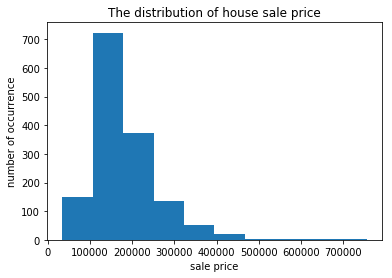

In [7]:
plt.hist(houseprices_df.saleprice)
plt.title('The distribution of house sale price')
plt.xlabel('sale price')
plt.ylabel('number of occurrence')
plt.show()

Looking at numeric features first

In [8]:
numerics_df = houseprices_df.select_dtypes(include=[np.number])
numerics_df.head()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


In [9]:
numerics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 38 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
masvnrarea       1452 non-null float64
bsmtfinsf1       1460 non-null int64
bsmtfinsf2       1460 non-null int64
bsmtunfsf        1460 non-null int64
totalbsmtsf      1460 non-null int64
firstflrsf       1460 non-null int64
secondflrsf      1460 non-null int64
lowqualfinsf     1460 non-null int64
grlivarea        1460 non-null int64
bsmtfullbath     1460 non-null int64
bsmthalfbath     1460 non-null int64
fullbath         1460 non-null int64
halfbath         1460 non-null int64
bedroomabvgr     1460 non-null int64
kitchenabvgr     1460 non-null int64
totrmsabvgrd     1460 non-null int64
f

In [10]:
#look at correlation of each potential numeric feature with target
np.abs(numerics_df.iloc[:,1:].corr().loc[:,'saleprice']).sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
mssubclass       0.084284
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: saleprice, dtype: float64

Choosing only variables with corr >0.5
overallqual     0.791
grlivarea       0.709
garagecars      0.640
garagearea      0.623
totalbsmtsf     0.614
firstflrsf      0.606
fullbath        0.561
totrmsabvgrd    0.534
yearbuilt       0.523
yearremodadd    0.507

In [11]:
#potential features from numeric columns: 
num_features = ['overallqual', 'grlivarea', 'garagecars', 
                'garagearea', 'totalbsmtsf', 'firstflrsf', 
                'fullbath', 'totrmsabvgrd', 'yearbuilt',
                'yearremodadd']

In [12]:
houseprices_df[num_features].isnull().sum()

overallqual     0
grlivarea       0
garagecars      0
garagearea      0
totalbsmtsf     0
firstflrsf      0
fullbath        0
totrmsabvgrd    0
yearbuilt       0
yearremodadd    0
dtype: int64

Looking at non-numeric variables

In [13]:
objects_df = houseprices_df.select_dtypes(include=[np.object])
objects_df.head()

,mszoning,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,...,garagetype,garagefinish,garagequal,garagecond,paveddrive,poolqc,fence,miscfeature,saletype,salecondition
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
3,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
4,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal


In [14]:
objects_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 43 columns):
mszoning         1460 non-null object
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-null object
exterior2nd      1460 non-null object
masvnrtype       1452 non-null object
exterqual        1460 non-null object
extercond        1460 non-null object
foundation       1460 non-null object
bsmtqual         1423 non-null object
bsmtcond         1423 non-null object
bsmtexposure     1422

In [15]:
non_numeric_columns = houseprices_df.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 43


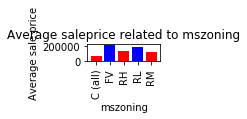

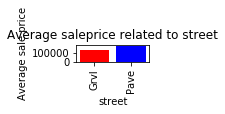

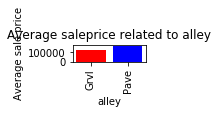

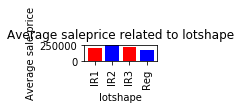

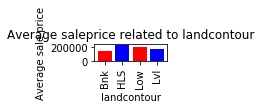

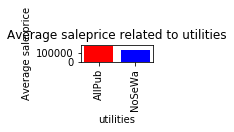

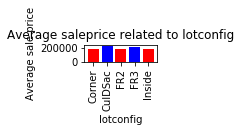

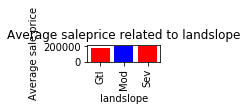

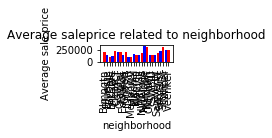

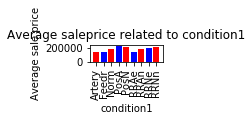

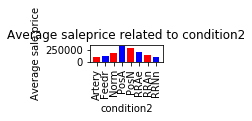

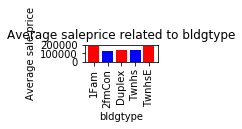

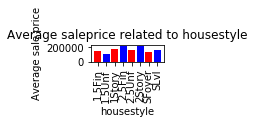

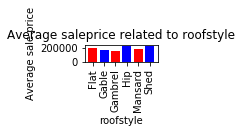

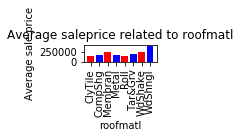

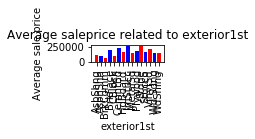

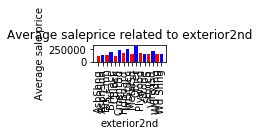

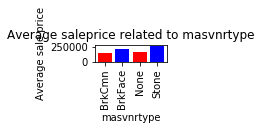

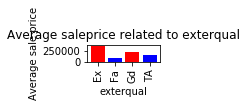

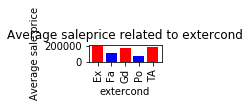

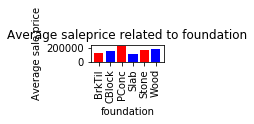

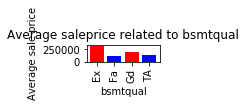

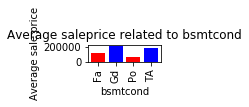

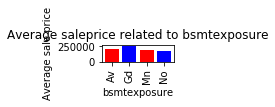

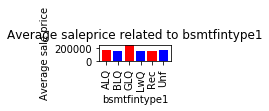

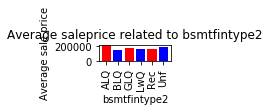

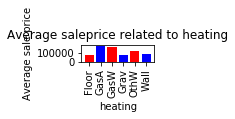

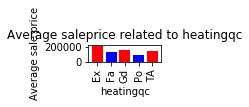

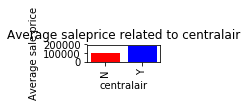

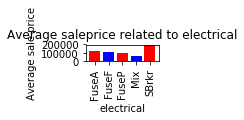

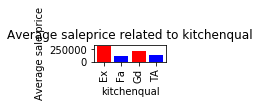

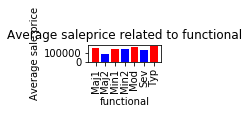

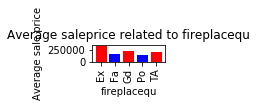

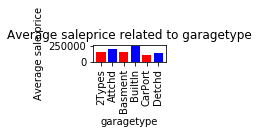

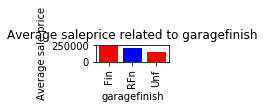

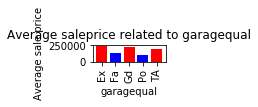

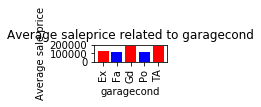

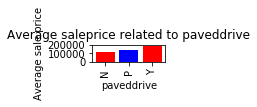

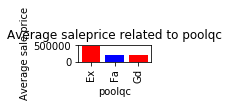

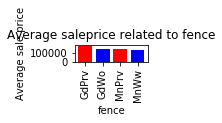

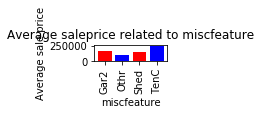

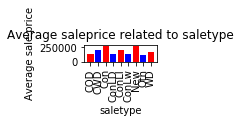

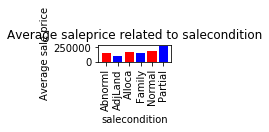

In [18]:
#to plot all non-numeric columns, from sample
for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(houseprices_df.groupby(column)['saleprice'].mean().index, houseprices_df.groupby(column)['saleprice'].mean(),
            color=('red','blue'))
    plt.title('Average saleprice related to {}'.format(column))
    plt.ylabel('Average sale price')
    plt.xlabel(column)
    plt.xticks(rotation='vertical')
    
    plt.tight_layout()
    plt.show()

###### categorical values = 
'neighborhood', string values (20)
#this is probably important
'bsmtcond', string values (6)
'heatingqc', string values (5)
'centralair', string, yes/no
'kitchenqual', string values (5)
'paveddrive', string values (3)

In [19]:
houseprices_df['central_air_ohc'] = pd.get_dummies(houseprices_df.centralair, drop_first=True)

In [20]:
mszoning_ohc_df = pd.get_dummies(houseprices_df.mszoning, prefix = 'mszoning', drop_first=True)
mszoning_ohc_df.head()

,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


In [21]:
kitchenqual_ohc_df = pd.get_dummies(houseprices_df.kitchenqual, prefix = 'kitchenqual',drop_first=True)
kitchenqual_ohc_df.head()

,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA
0,0,1,0
1,0,0,1
2,0,1,0
3,0,1,0
4,0,1,0


In [22]:
houseprices_df = pd.concat([houseprices_df, kitchenqual_ohc_df], axis=1)
houseprices_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,miscval,mosold,yrsold,saletype,salecondition,saleprice,central_air_ohc,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,2,2008,WD,Normal,208500,1,0,1,0
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,5,2007,WD,Normal,181500,1,0,0,1
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,9,2008,WD,Normal,223500,1,0,1,0
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,2,2006,WD,Abnorml,140000,1,0,1,0
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,12,2008,WD,Normal,250000,1,0,1,0


In [23]:
houseprices_df = pd.concat([houseprices_df, mszoning_ohc_df], axis=1)
houseprices_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,salecondition,saleprice,central_air_ohc,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,Normal,208500,1,0,1,0,0,0,1,0
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,Normal,181500,1,0,0,1,0,0,1,0
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,Normal,223500,1,0,1,0,0,0,1,0
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,Abnorml,140000,1,0,1,0,0,0,1,0
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,Normal,250000,1,0,1,0,0,0,1,0


In [24]:
numerics_df = houseprices_df.select_dtypes(include=[np.number])
numerics_df.head()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,yrsold,saleprice,central_air_ohc,kitchenqual_Fa,kitchenqual_Gd,kitchenqual_TA,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,2008,208500,1,0,1,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,2007,181500,1,0,0,1,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,2008,223500,1,0,1,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,2006,140000,1,0,1,0,0,0,1,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,2008,250000,1,0,1,0,0,0,1,0


In [25]:
np.abs(numerics_df.iloc[:,1:].corr().loc[:,'saleprice']).sort_values(ascending=False)

saleprice          1.000000
overallqual        0.790982
grlivarea          0.708624
garagecars         0.640409
garagearea         0.623431
totalbsmtsf        0.613581
firstflrsf         0.605852
fullbath           0.560664
totrmsabvgrd       0.533723
yearbuilt          0.522897
kitchenqual_TA     0.519298
yearremodadd       0.507101
garageyrblt        0.486362
masvnrarea         0.477493
fireplaces         0.466929
bsmtfinsf1         0.386420
lotfrontage        0.351799
wooddecksf         0.324413
kitchenqual_Gd     0.321641
secondflrsf        0.319334
openporchsf        0.315856
mszoning_RM        0.288065
halfbath           0.284108
lotarea            0.263843
central_air_ohc    0.251328
mszoning_RL        0.245063
bsmtfullbath       0.227122
bsmtunfsf          0.214479
bedroomabvgr       0.168213
kitchenqual_Fa     0.157199
kitchenabvgr       0.135907
enclosedporch      0.128578
screenporch        0.111447
poolarea           0.092404
mszoning_FV        0.089950
mssubclass         0

Choosing only features with corr >0.5
overallqual        0.790982
grlivarea          0.708624
garagecars         0.640409
garagearea         0.623431
totalbsmtsf        0.613581
firstflrsf         0.605852
fullbath           0.560664
totrmsabvgrd       0.533723
yearbuilt          0.522897
TA                 0.519298
kitchenqual_TA     0.519298
yearremodadd       0.507101

In [26]:
features = ['overallqual', 'grlivarea', 'garagecars',
            'garagearea', 'totalbsmtsf', 'firstflrsf', 
            'fullbath', 'totrmsabvgrd', 'yearbuilt',
            'yearremodadd', 'kitchenqual_TA']

In [27]:
houseprices_df[features].isnull().sum()

overallqual       0
grlivarea         0
garagecars        0
garagearea        0
totalbsmtsf       0
firstflrsf        0
fullbath          0
totrmsabvgrd      0
yearbuilt         0
yearremodadd      0
kitchenqual_TA    0
dtype: int64

###### fit model
Y = houseprices_df['saleprice']
X is the feature set: houseprices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'firstflrsf', 'fullbath', 'totrmsabvgrd', 'yearbuilt',
'yearremodadd', 'kitchenqual_TA']]


In [28]:
# Y is the target variable
Y = houseprices_df['saleprice']
# X is the feature set 
X = houseprices_df[['overallqual', 'grlivarea', 'garagecars',
            'garagearea', 'totalbsmtsf', 'firstflrsf', 
            'fullbath', 'totrmsabvgrd', 'yearbuilt',
            'yearremodadd', 'kitchenqual_TA']]

# create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [ 1.87828228e+04  4.99680088e+01  1.04113769e+04  1.43382780e+01
  1.98410904e+01  1.43914025e+01 -7.47959886e+03  4.39276356e+02
  2.62300724e+02  2.18877628e+02 -9.03887736e+03]

Intercept: 
 -1010372.4726448985


In [29]:
import statsmodels.api as sm

# need to manually add a constant in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     454.8
Date:                Mon, 21 Oct 2019   Prob (F-statistic):               0.00
Time:                        10:04:54   Log-Likelihood:                -17453.
No. Observations:                1460   AIC:                         3.493e+04
Df Residuals:                    1448   BIC:                         3.499e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -1.01e+06   1.38e+05     -7.305      0.000   -1.28e+06   -7.39e+05
overallqual     1.878e+04   1209.243     15.533      0.000    1.64e+04    2.12e+04
grlivarea         49.9680      4.234     11.801      0.000      41.662      58.274
garagecars      1.041e+04   3032.818      3.433      0.001    4462.191    1.64e+04
garagearea        14.3383     10.274      1.396      0.163      -5.815      34.492
totalbsmtsf       19.8411      4.279      4.637      0.000      11.447      28.235
firstflrsf        14.3914      4.912      2.930      0.003       4.757      24.026
fullbath       -7479.5989   2679.682     -2.791      0.005   -1.27e+04   -2223.125
totrmsabvgrd     439.2764   1121.016      0.392      0.695   -1759.713    2638.266
yearbuilt        262.3007     50.186      5.227      0.000     163.855     360.746
yearremodadd     218.8776     67.247      3.255      0.001      86.965     350.790
kitchenqual_TA -9038.8774   2612.934     -3.459      0.001   -1.42e+04   -3913.337
==============================================================================
Omnibus:                      465.727   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58449.083
Skew:                          -0.341   Prob(JB):                         0.00
Kurtosis:                      33.989   Cond. No.                     5.05e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

###### Assumption one: linearity of the model in its coefficients

Y = houseprices_df['saleprice']
X is the feature set: houseprices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'firstflrsf', 'fullbath', 'totrmsabvgrd', 'yearbuilt',
'yearremodadd', 'kitchenqual_TA']]

X = sm.add_constant(X)

In [36]:
#currently doesn't work
# equation: Y = 1 + 2*X + 3*X^2

houseprices_df['X'] = houseprices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'firstflrsf', 'fullbath', 'totrmsabvgrd', 'yearbuilt',
'yearremodadd', 'kitchenqual_TA']]
houseprices_df['X_sq'] = houseprices_df['X']**2
houseprices_df['Y'] = 1 + 2*houseprices_df['X'] + 3*houseprices_df['X_sq']

# fit a linear regression where target is Y
# and features are X and X^2
lrm_example = linear_model.LinearRegression()
lrm_example.fit(houseprices_df[[X, X_sq]], houseprices_df[[Y]])

# predictions of the linear regression
predictions = lrm_example.predict(houseprices_df[[X,X_sq]])

# print the estimated coefficients
print('\nCoefficients: \n', lrm_example.coef_)
print('\nIntercept: \n', lrm_example.intercept_)

# plot the estimated Y and X
# the relationship should be quadratic
plt.scatter(houseprices_df['X'], predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Linear regression can capture quadratic relationship')
plt.show()

ValueError: Wrong number of items passed 11, placement implies 1

###### Assumption two: the error term should be zero on average

In [30]:
predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the weather model is: {}".format(np.mean(errors)))

ValueError: shapes (1460,12) and (11,) not aligned: 12 (dim 1) != 11 (dim 0)

###### Assumption three: homoscedasticity

In [32]:
predictions = lrm.predict(X)
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

ValueError: shapes (1460,12) and (11,) not aligned: 12 (dim 1) != 11 (dim 0)

In [34]:
predictions = lrm.predict(X)
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

ValueError: shapes (1460,12) and (11,) not aligned: 12 (dim 1) != 11 (dim 0)

###### Assumption four: low multicollinearity

In [ ]:
#run corr of features only, not against target
np.abs(weather_df[numerics].iloc[:,1:].corr().loc[:,'temperature']).sort_values(ascending=False)

###### Assumption five: error terms should be uncorrelated with one another

In [ ]:
plt.plot(errors)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

###### Assumption six: features shouldn't be correlated with the errors

In [ ]:
#???
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

In [ ]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))